In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from copy import deepcopy
from pprint import pprint

# Question 1

In [2]:
# Function to download stocks
def download_crypto_prices(symbols, start = '2019-02-01', end = '2022-02-01'):
    prices = {}
    for symbol in symbols: 
        df = yf.download(symbol, start = start, end = end)
        df['Log_Returns'] = np.log(df['Adj Close']/ df['Adj Close'].shift(1)) #“ln(St+1/St)”
        prices[symbol] = df[['Adj Close', 'Log_Returns']]
    return prices

symbols = ['BTC-USD', 'ETH-USD', 'DOGE-USD', 'MATIC-USD']
prices = download_crypto_prices(symbols)

crypto_list = [prices[symbol]['Log_Returns'].rename(symbol) for symbol in symbols]
returns_df = pd.concat(crypto_list, axis = 1)
returns_df.loc["2020-02-01":"2022-02-02"].head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BTC-USD,ETH-USD,DOGE-USD,MATIC-USD
Date,,,,
2020-02-01,0.004518,0.019316,0.011628,0.022230
2020-02-02,-0.005178,0.026559,0.018814,0.041880
2020-02-03,-0.005456,0.006592,-0.011410,0.144471
2020-02-04,-0.012185,-0.003242,0.025492,-0.044297
2020-02-05,0.046028,0.076176,0.031074,0.014285


In [3]:
returns_df.loc["2019-04-29":"2022-02-01"].isna().sum()

BTC-USD      0
ETH-USD      0
DOGE-USD     0
MATIC-USD    0
dtype: int64

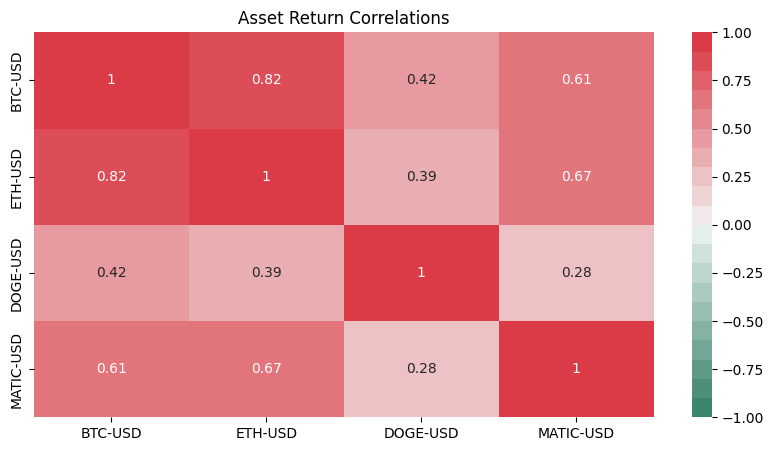

In [4]:
plt.figure(figsize=(10, 5))
sns.heatmap(round(returns_df.loc["2020-02-01":"2022-02-01"].dropna().corr(), 2), cmap=sns.diverging_palette(160, 10, n = 20), annot=True, vmin=-1, vmax=1)
plt.title("Asset Return Correlations")
plt.savefig('Asset Return Correlations.png')

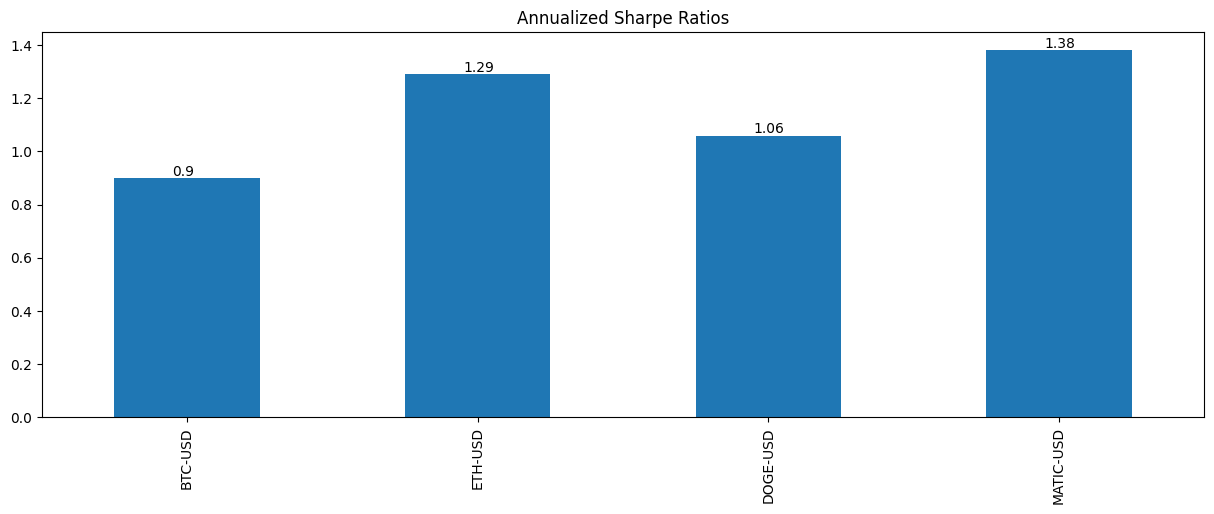

In [5]:
# calculate Sharpe Ratio, and annualize it by multiplying sqrt(365)
ax = round(returns_df.loc["2020-02-01":"2022-02-01"].dropna().mean(axis = 0) / returns_df.loc["2020-02-01":"2022-02-01"].dropna().std(axis = 0) * 365 ** 0.5, 2).plot(kind="bar", figsize = (15, 5))

plt.title("Annualized Sharpe Ratios")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.2, p.get_height() + 0.01))

plt.savefig('Annualized Sharpe Ratios.png')

In [6]:
returns_df.loc["2020-02-01":"2022-02-02"]

,BTC-USD,ETH-USD,DOGE-USD,MATIC-USD
Date,,,,
2020-02-01,0.004518,0.019316,0.011628,0.022230
2020-02-02,-0.005178,0.026559,0.018814,0.041880
2020-02-03,-0.005456,0.006592,-0.011410,0.144471
2020-02-04,-0.012185,-0.003242,0.025492,-0.044297
2020-02-05,0.046028,0.076176,0.031074,0.014285
...,...,...,...,...
2022-01-27,0.007734,-0.018413,-0.017837,0.000395
2022-01-28,0.017248,0.049945,0.002891,0.053536
2022-01-29,0.009321,0.019437,0.009835,0.009334


# Question 2

In [7]:
import cvxpy as cvx

In [8]:
def get_optimized_portfolio(returns_df, returns_scale = .0001, max_holding = 0.5):
    """
    Function that takes in the returns series of assets, minimizes the utility function, 
    and returns the portfolio weights
    
    Parameters
    ----------
    returns_df : pd.dataframe
        Dataframe containing log asset return series in each column
    
    returns_scale : float
        The scaling factor applied to the returns
        
    max_holding : float
        The maximum weight a stock can hold.
        
    Returns
    -------
    x : np.ndarray
        A numpy ndarray containing the weights of the assets in the optimized portfolio
    """
    
    # convert returns dataframe to numpy array
    returns = returns_df.T.to_numpy()
    # m is the number of assets
    m = returns.shape[0]
  
    # covariance matrix of returns
    cov = np.cov(returns)
    
    # creating variable of weights to optimize
    x = cvx.Variable(m)
    
    # portfolio variance, in quadratic form
    portfolio_variance = cvx.quad_form(x, cov)

    log_returns_df = np.log(returns_df+1)

    total_return_log = log_returns_df.sum().to_numpy() #this is in log space, change to simple return


    total_simple_return = np.exp(total_return_log) -1
    frequency = 365 #assume daily compounding, we are going to take geometric average
    #this is the standard basic mean for optimization (to assume daily compounding)
    
    horizon_length = returns.shape[1]
    expected_mean = (1 + total_simple_return) ** (1 / horizon_length) - 1

    #let's assume 
    # element wise multiplication, followed up by sum of weights
    portfolio_return = sum(cvx.multiply(expected_mean, x))
    
    # Objective Function
    # We want to minimize variance and maximize returns. We can also minimize the negative of returns.
    # Therefore, variance has to be a positive and returns have to be a negative.
    objective = cvx.Minimize(portfolio_variance - returns_scale * portfolio_return)
    
    # Constraints
    # long only, sum of weights equal to 1, no allocation to a single stock great than 50% of portfolio
    constraints = [x >= 0, sum(x) == 1, x <= max_holding]

    # use cvxpy to solve the objective
    problem = cvx.Problem(objective, constraints)
    # retrieve the weights of the optimized portfolio
    result = problem.solve()
    
    return x.value

In [9]:
# MATIC log returns data available from 2019-04-29
datagrab = len(returns_df.loc["2019-04-29":"2020-01-31"])
datagrab

278

In [10]:
start_index = returns_df.index.get_loc("2020-02-01")
weights_list_unlimited = []
weights_list_limited = []

for i in range(start_index, len(returns_df)): #len(returns_df)+1
    # get subset of data needed for the specific date -- backtrack 278 days
    sub_returns_df = returns_df.iloc[i-datagrab+1:i+1] 
    
    weights_unlimited = get_optimized_portfolio(sub_returns_df, returns_scale = 0, max_holding=1)
    weights_list_unlimited.append(weights_unlimited.tolist())
    
    weights_limited = get_optimized_portfolio(sub_returns_df, returns_scale = 0, max_holding=0.5)
    weights_list_limited.append(weights_limited.tolist())

weights_unlimited_df = pd.DataFrame(weights_list_unlimited, columns = returns_df.columns, index=returns_df.loc["2020-02-01":"2022-02-01"].index)
weights_limited_df = pd.DataFrame(weights_list_limited, columns = returns_df.columns, index=returns_df.loc["2020-02-01":"2022-02-01"].index)


<Axes: title={'center': 'Portfolio with the Maximum Holding Weight Limited to 0.5'}, xlabel='Date'>

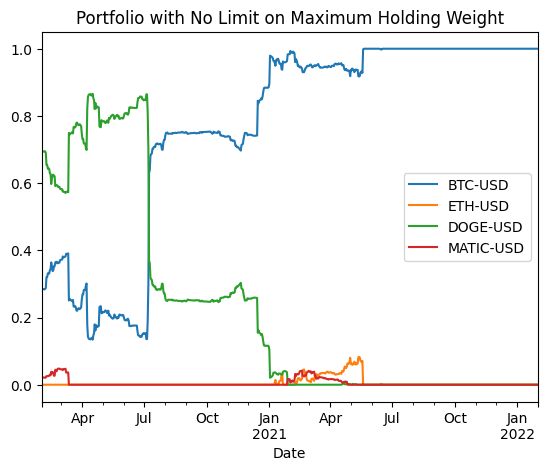

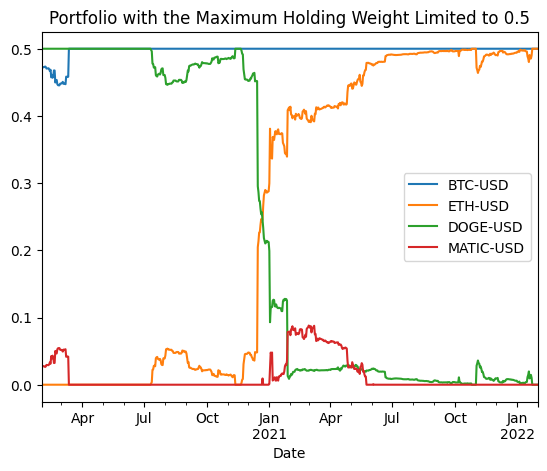

In [43]:
weights_unlimited_df.plot(title='Portfolio with No Limit on Maximum Holding Weight')
weights_limited_df.plot(title='Portfolio with the Maximum Holding Weight Limited to 0.5')

In [11]:
def compute_log_portfolio_returns(log_returns, weights):
      
    #removed print statements
    #implicitly this assumes daily rebalancing - weights are equal everyday
    weighted_returns = (np.exp(log_returns) - 1) * weights
    portfolio_returns = np.sum(weighted_returns, axis=1)
    log_returns = np.log(portfolio_returns + 1)
    
    return log_returns

In [12]:
returns_df_2 = returns_df.loc["2020-02-01":"2022-02-01"]

portfolio_unlimited = compute_log_portfolio_returns(returns_df_2, weights_unlimited_df)
portfolio_limited = compute_log_portfolio_returns(returns_df_2, weights_limited_df)

all_portfolio_returns = pd.concat(
    [portfolio_unlimited, portfolio_limited], axis = 1)
all_portfolio_returns.columns = ["Portfolio_Unlimited", "Portfolio_Limited"]

In [13]:
prices['Portfolio'] = portfolio_unlimited.rename('Log_Returns').to_frame()

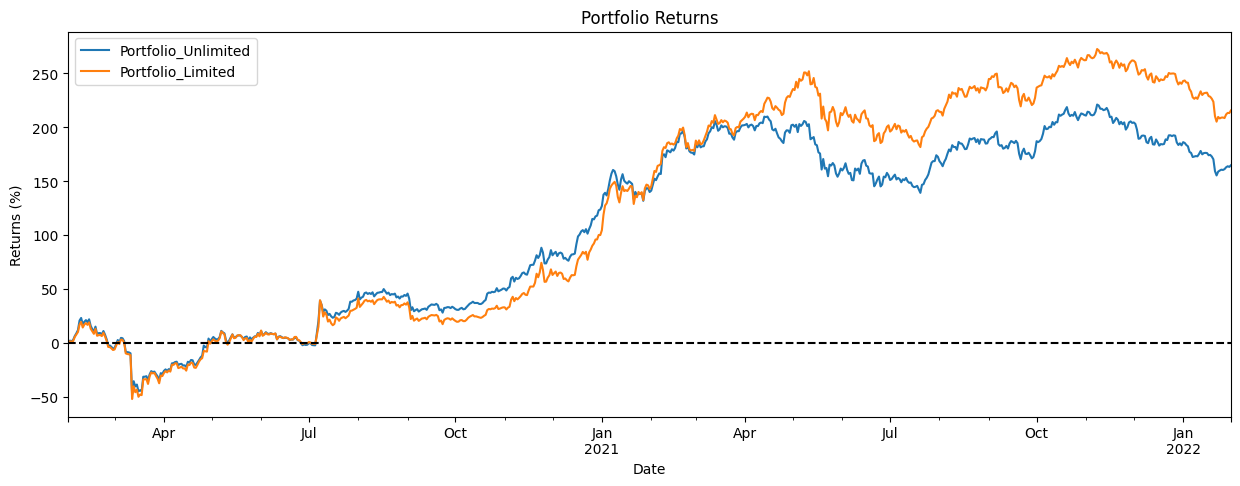

In [19]:
all_portfolio_returns.expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (15, 5))
plt.title("Portfolio Returns")
plt.ylabel("Returns (%)")
plt.axhline(y=0, color='black', linestyle='--')

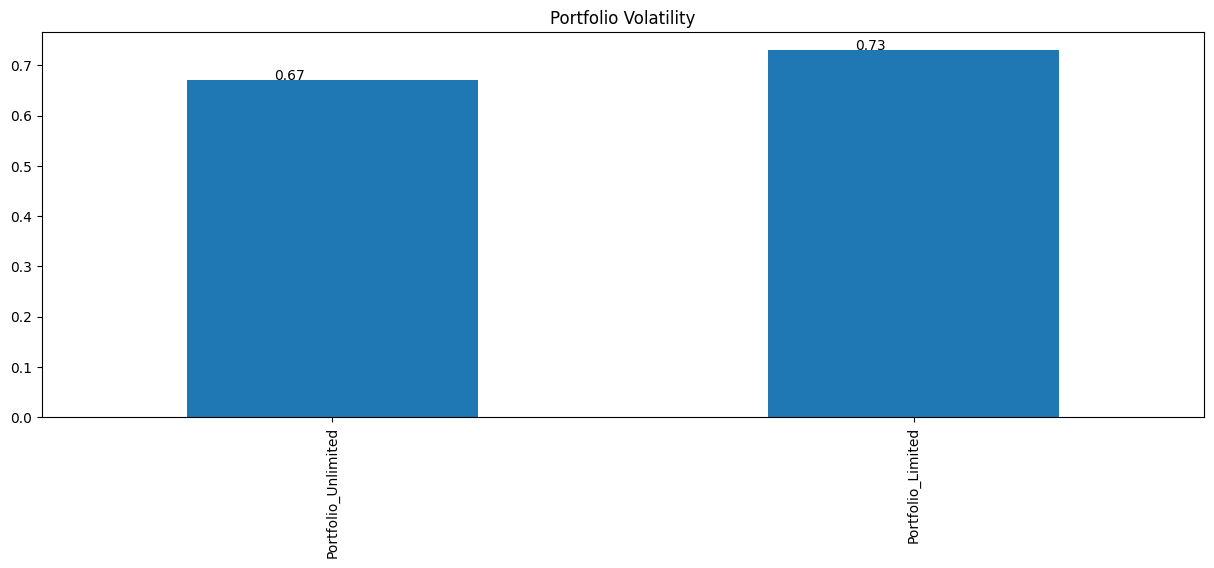

In [20]:
ax = round(all_portfolio_returns.std(axis = 0) * datagrab ** 0.5, 2).plot(kind="bar", figsize = (15, 5))
plt.title("Portfolio Volatility")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.001))

# Question 3

In [14]:
def calc_historical_VaR(log_returns, alpha):
    log_var = log_returns.quantile(alpha)
    var = np.exp(log_var) - 1
    return -var

def calc_historical_ES(log_returns, alpha):
    log_var = log_returns.quantile(alpha)
    log_es = sum(log_returns[log_returns < log_var]) / (alpha * len(log_returns))
    percentage_es = np.exp(log_es) - 1
    return -percentage_es

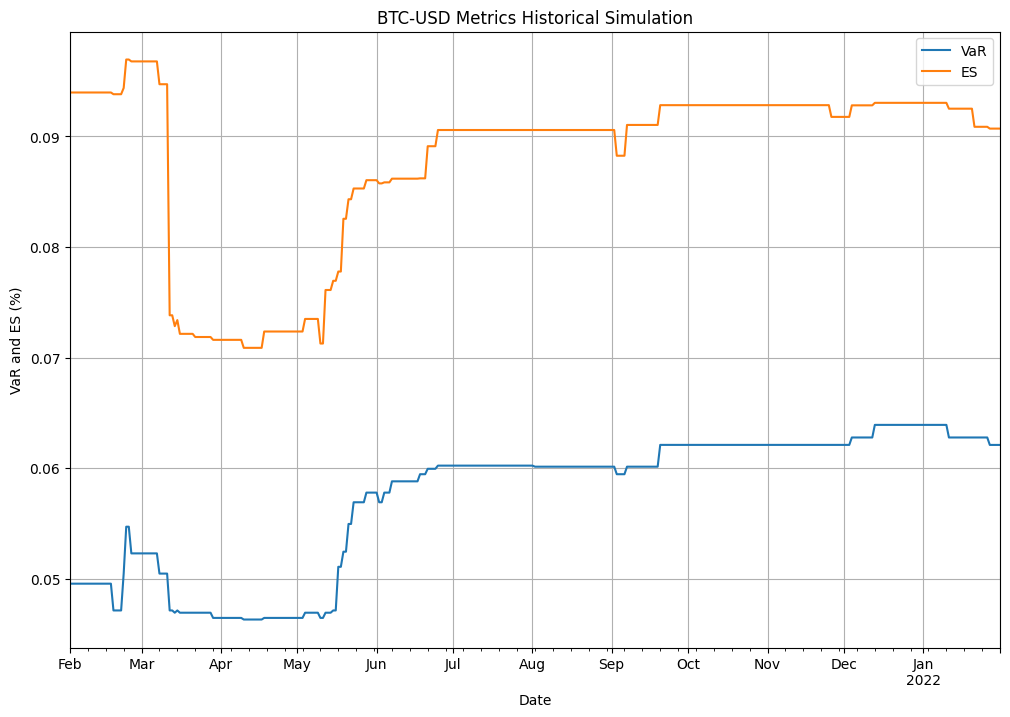

In [46]:
keys = symbols + ['Portfolio']

for key in keys:
    df = deepcopy(prices[key])
    df.loc[:,'VaR'] = df['Log_Returns'].rolling(365).apply(lambda x: calc_historical_VaR(x, 0.05))
    df.loc[:,'ES'] = df['Log_Returns'].rolling(365).apply(lambda x: calc_historical_ES(x, 0.05))
    prices[key] = df

var_plot_df = pd.concat([prices[key]['VaR'] for key in keys], axis=1, keys=keys)
es_plot_df = pd.concat([prices[key]['ES'] for key in keys], axis=1, keys=keys)

btc_plot_fig = prices['BTC-USD'].loc[(prices['BTC-USD'].index >= '2021-02-01') & (prices['BTC-USD'].index <= '2022-02-01'), ['VaR', 'ES']].plot(
    grid=True, figsize=(12,8), xlabel='Date', ylabel='VaR and ES (%)', title='BTC-USD Metrics Historical Simulation')

btc_plot_fig.figure.savefig('BTC-USD Metrics Historical Simulation.png')

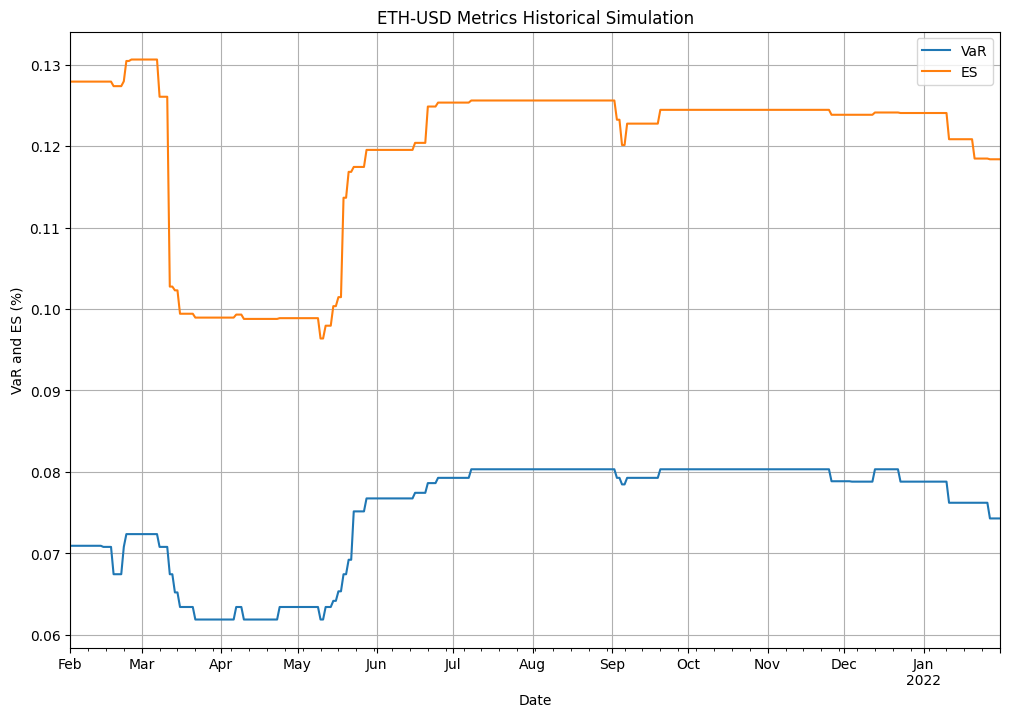

In [223]:
eth_plot_fig = prices['ETH-USD'].loc[(prices['ETH-USD'].index >= '2021-02-01') & (prices['ETH-USD'].index <= '2022-02-01'), ['VaR', 'ES']].plot(
    grid=True, figsize=(12,8), xlabel='Date', ylabel='VaR and ES (%)', title='ETH-USD Metrics Historical Simulation')

eth_plot_fig.figure.savefig('ETH-USD Metrics Historical Simulation.png')

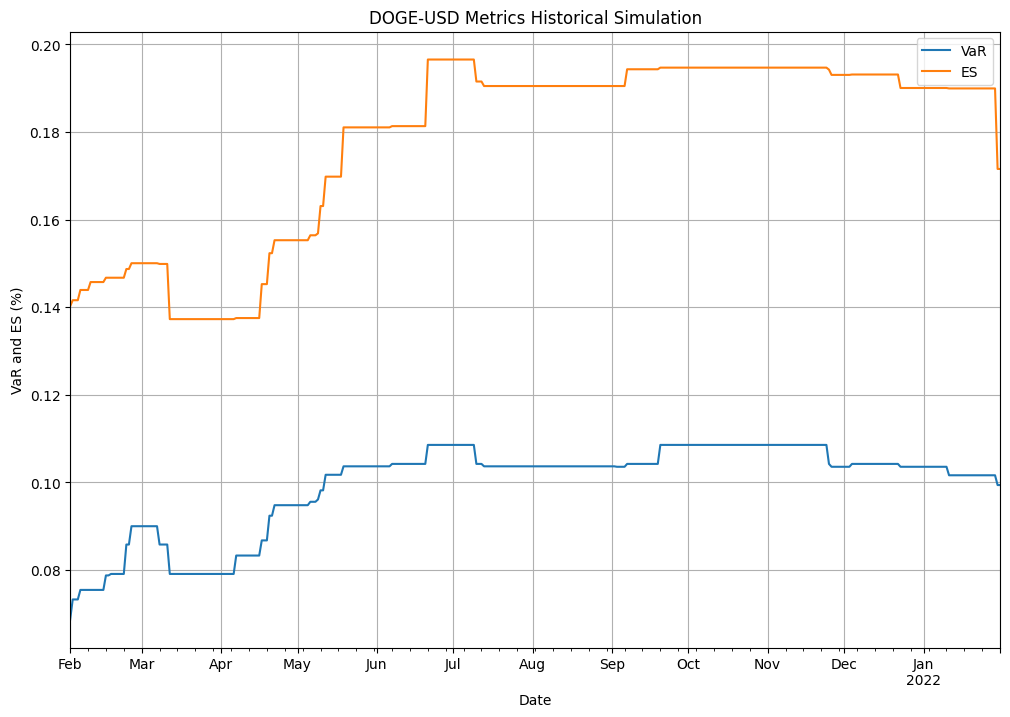

In [224]:
doge_plot_fig = prices['DOGE-USD'].loc[(prices['DOGE-USD'].index >= '2021-02-01') & (prices['DOGE-USD'].index <= '2022-02-01'), ['VaR', 'ES']].plot(
    grid=True, figsize=(12,8), xlabel='Date', ylabel='VaR and ES (%)', title='DOGE-USD Metrics Historical Simulation')

doge_plot_fig.figure.savefig('DOGE-USD Metrics Historical Simulation.png')

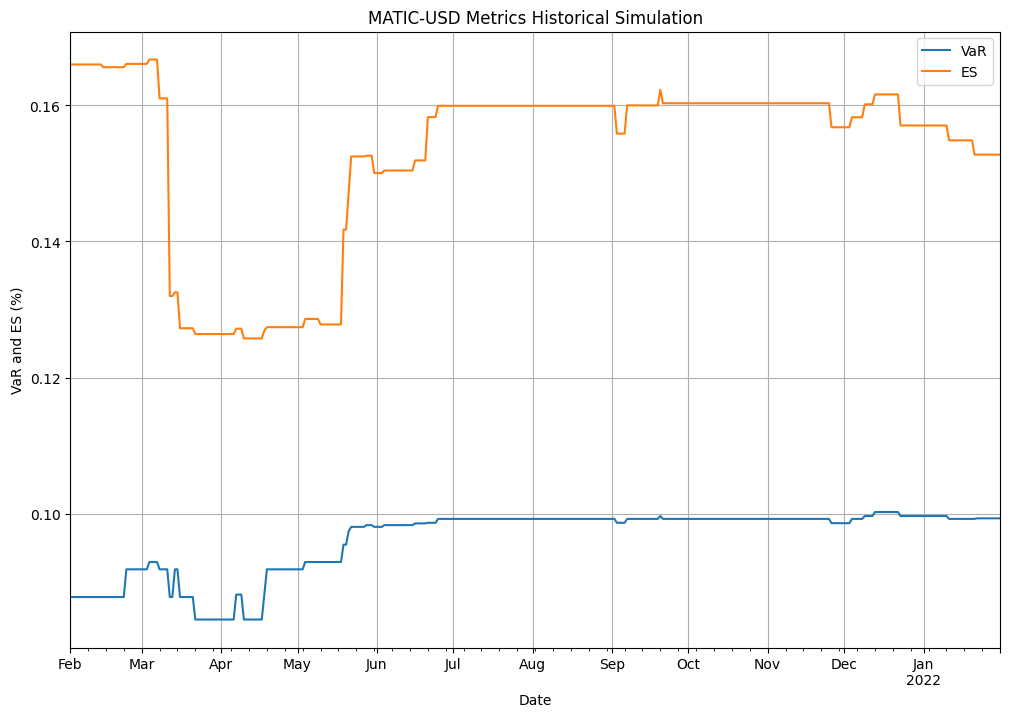

In [225]:
matic_plot_fig = prices['MATIC-USD'].loc[(prices['MATIC-USD'].index >= '2021-02-01') & (prices['MATIC-USD'].index <= '2022-02-01'), ['VaR', 'ES']].plot(
    grid=True, figsize=(12,8), xlabel='Date', ylabel='VaR and ES (%)', title='MATIC-USD Metrics Historical Simulation')

matic_plot_fig.figure.savefig('MATIC-USD Metrics Historical Simulation.png')

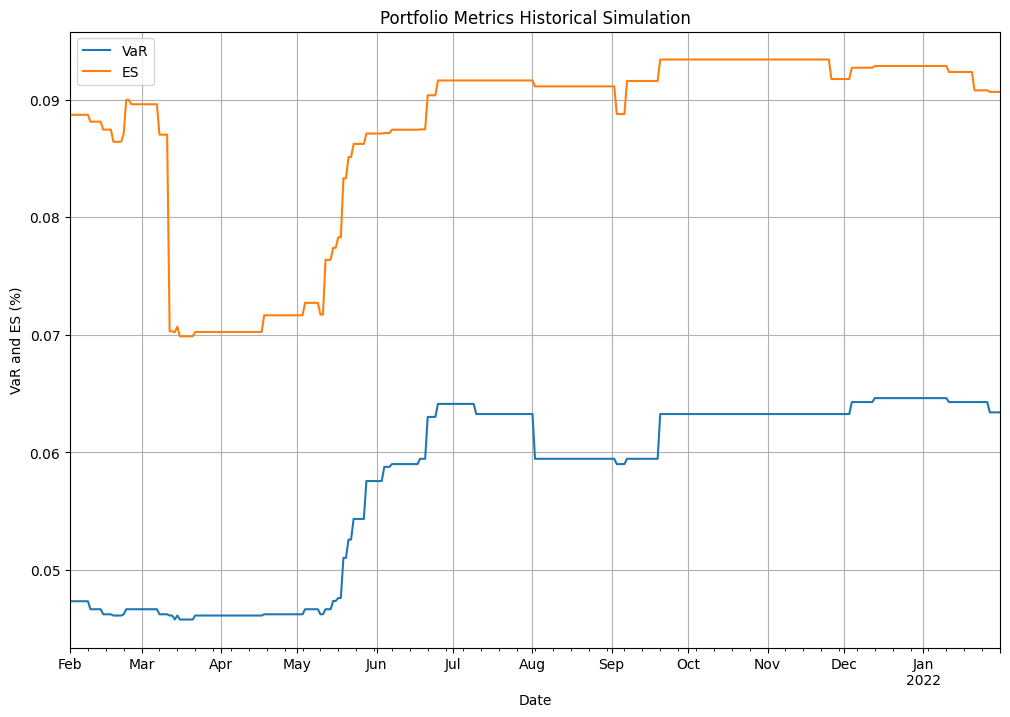

In [232]:
portfolio_plot_fig = prices['Portfolio'].loc[(prices['Portfolio'].index >= '2021-02-01') & (prices['Portfolio'].index <= '2022-02-01'), ['VaR', 'ES']].plot(
    grid=True, figsize=(12,8), xlabel='Date', ylabel='VaR and ES (%)', title='Portfolio Metrics Historical Simulation')

portfolio_plot_fig.figure.savefig('Portfolio Metrics Historical Simulation.png')

# Question 4

In [20]:
from pandas_datareader.data import DataReader

import requests_cache
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

# just add headers to your session and provide it to the reader
session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
                   'Accept': 'application/json;charset=utf-8'}

def get_data_for_multiple_stocks(tickers,start_date='2017-01-01',end_date= '2022-12-31'):
    stocks = dict()
    for ticker in tickers: 
        format='%Y-%m-%d'
        s = yf.download(ticker, dt.datetime.strptime(start_date, format), dt.datetime.strptime(end_date, format))
        s.insert(0, "Ticker", ticker)  #insert ticker column so you can reference better later
        
        s['Prev Close'] = s['Adj Close'].shift(1)
        s['log_return'] = np.log(s['Adj Close']/s['Prev Close'])
        s['perc_return'] = (s['Adj Close']/s['Prev Close']) - 1
        stocks[ticker] = s
    return stocks

## (a) Compare Bitcoin (BTC-USD) and Ether (ETH-USD), which coin’s prices do you think is more volatile? (You can choose to also consider the upside and downside risks separately.)


In [ ]:
tickers = ['BTC-USD','ETH-USD']
tickers_df =  get_data_for_multiple_stocks(tickers,start_date='2020-02-01',end_date= '2022-02-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
btc_log_return = tickers_df['BTC-USD']['log_return'].dropna()
eth_log_return = tickers_df['ETH-USD']['log_return'].dropna()

In [ ]:
print('variance of log return for BTC-USD is', btc_log_return.var(), sep ='\n')
print('variance of log return for ETH-USD is', eth_log_return.var(), sep ='\n')
print('-'*40)
print('downside risk of BTC-USD is', btc_log_return[btc_log_return<0].var(), sep ='\n')
print('downside risk of ETH-USD is', eth_log_return[eth_log_return<0].var(), sep ='\n')
print('-'*40)
print('Conclusion: ETH is more volatile than BTC.')

variance of log return for BTC-USD is
0.0016884885834435905
variance of log return for ETH-USD is
0.0029764014534492305
----------------------------------------
downside risk of BTC-USD is
0.0012551314083512352
downside risk of ETH-USD is
0.0021885072024369905
----------------------------------------
Conclusion: ETH is more volatile than BTC.


## (b) For your no limit setting portfolio from Q2, on 2021/01/01, for each one unit of the asset your team deemed to be the most volatile, buy one straddle (buy one put + buy one call). That expires on 2021/01/08. You can choose the exercise prices as close as to minus/plus one standard deviation of asset return (minus one standard deviation for buying a put and plus one standard deviation for buying a call option). You can determine your cost using the last transacted option prices on 2021/01/01 as the market price. Suppose your cost is externally financed and to be returned/deducted on 2021/01/08, with no interest rate. 
## What are the instrument_ids that you decided to buy?

In [ ]:
#dataset is kind of messy. has to preprocess and clean it first

options_df = pd.read_csv("OKEx_options_trade.csv")
#Clean the data first, some rows are not instruments
options_df = options_df.iloc[1:-1]
options_df = options_df[options_df.timestamp != 'timestamp']
options_df.reset_index(inplace = True)
options_df = options_df[['side','price','qty','instrument_id','timestamp']]

In [ ]:
options_df

,side,price,qty,instrument_id,timestamp
0,buy,0.0315,10,BTC-USD-200327-8000-P,2020-01-31T10:19:38.359Z
1,buy,0.026,1,BTC-USD-200207-9500-C,2020-01-31T22:52:29.429Z
2,buy,0.052,50,BTC-USD-200327-11000-C,2020-01-31T22:13:11.537Z
3,sell,0.003,40,BTC-USD-200207-8250-P,2020-01-31T13:40:34.053Z
4,buy,0.0005,85,BTC-USD-200207-6000-P,2020-01-31T13:02:45.678Z
...,...,...,...,...,...
100589,sell,0.1845,1,ETH-USD-211231-4000-C,2021-12-01T23:57:38.608Z
100590,sell,0.0085,1,ETH-USD-211203-4700-C,2021-12-01T23:57:59.504Z
100591,buy,0.0445,1,ETH-USD-211210-4700-C,2021-12-01T23:58:12.061Z
100592,buy,0.0205,6,ETH-USD-211203-4600-C,2021-12-01T23:58:48.285Z


In [ ]:
#sort the datasete and only remove the BTC options
#sort the df chronologically
options_df['timestamp'] = pd.to_datetime(options_df['timestamp'])
options_df = options_df.sort_values(by=['timestamp'])
# keep only ETH instrument
options_df = options_df[options_df['instrument_id'].str.startswith('ETH')]
options_df.reset_index(inplace = True, drop = True)

In [ ]:
options_df

,side,price,qty,instrument_id,timestamp
0,buy,0.014,3,ETH-USD-200925-480-C,2020-06-27 08:46:32.752000+00:00
1,buy,0.014,3,ETH-USD-200925-480-C,2020-06-27 08:46:32.752000+00:00
2,sell,0.0015,10,ETH-USD-200703-260-C,2020-06-27 16:47:22.841000+00:00
3,sell,0.0015,10,ETH-USD-200703-260-C,2020-06-27 16:47:22.841000+00:00
4,sell,0.0015,10,ETH-USD-200703-260-C,2020-06-27 16:47:22.841000+00:00
...,...,...,...,...,...
43014,sell,0.032,1,ETH-USD-211210-4800-C,2021-12-01 23:56:10.701000+00:00
43015,sell,0.1845,1,ETH-USD-211231-4000-C,2021-12-01 23:57:38.608000+00:00
43016,sell,0.0085,1,ETH-USD-211203-4700-C,2021-12-01 23:57:59.504000+00:00
43017,buy,0.0445,1,ETH-USD-211210-4700-C,2021-12-01 23:58:12.061000+00:00


In [ ]:
#calculate the mean and variance of log return from 2020-02-01 ~ 2020-12-31
#we buy option on 2021-01-01 so we only retrieve the data til 2020-12-31

log_return_data = tickers_df['ETH-USD'].loc[:'2020-12-31']['log_return'].dropna()
log_return_mean = log_return_data.mean()
log_return_std = log_return_data.std()

current_price = tickers_df['ETH-USD'].loc['2020-12-31']['Adj Close']
call_exercise_price = current_price * np.exp(log_return_mean + log_return_std)
put_exercise_price = current_price * np.exp(log_return_mean - log_return_std)
print('---ETH---')
print('adj closed price on 2020-12-31:', current_price, sep='\n')
print('target_call_strike_price on 2021-01-01:', call_exercise_price, sep='\n')
print('target_put_strike_price on 2021-01-01:', put_exercise_price, sep='\n')

---ETH---
adj closed price on 2020-12-31:
737.8034057617188
target_call_strike_price on 2021-01-01:
781.7421206311457
target_put_strike_price on 2021-01-01:
702.220029661307


In [ ]:
options_df[['tmp1','tmp2', 'expiration', 'strike', 'option_type']] = options_df['instrument_id'].str.split('-', expand=True)


In [ ]:
options_df

,side,price,qty,instrument_id,timestamp,tmp1,tmp2,expiration,strike,option_type
0,buy,0.014,3,ETH-USD-200925-480-C,2020-06-27 08:46:32.752000+00:00,ETH,USD,200925,480,C
1,buy,0.014,3,ETH-USD-200925-480-C,2020-06-27 08:46:32.752000+00:00,ETH,USD,200925,480,C
2,sell,0.0015,10,ETH-USD-200703-260-C,2020-06-27 16:47:22.841000+00:00,ETH,USD,200703,260,C
3,sell,0.0015,10,ETH-USD-200703-260-C,2020-06-27 16:47:22.841000+00:00,ETH,USD,200703,260,C
4,sell,0.0015,10,ETH-USD-200703-260-C,2020-06-27 16:47:22.841000+00:00,ETH,USD,200703,260,C
...,...,...,...,...,...,...,...,...,...,...
43014,sell,0.032,1,ETH-USD-211210-4800-C,2021-12-01 23:56:10.701000+00:00,ETH,USD,211210,4800,C
43015,sell,0.1845,1,ETH-USD-211231-4000-C,2021-12-01 23:57:38.608000+00:00,ETH,USD,211231,4000,C
43016,sell,0.0085,1,ETH-USD-211203-4700-C,2021-12-01 23:57:59.504000+00:00,ETH,USD,211203,4700,C
43017,buy,0.0445,1,ETH-USD-211210-4700-C,2021-12-01 23:58:12.061000+00:00,ETH,USD,211210,4700,C


In [ ]:
call_df = options_df[(options_df['option_type'] == 'C') & (options_df['expiration'] == '210108')
                    & (options_df['timestamp'].dt.date == pd.to_datetime('2021-01-01').date())].copy()
call_df['strike_diff'] = abs(call_df['strike'].astype(float) - call_exercise_price)
call_df.sort_values('strike_diff', inplace = True)
call_row = call_df.iloc[0]

put_df = options_df[(options_df['option_type'] == 'P') & (options_df['expiration'] == '210108')
                    & (options_df['timestamp'].dt.date == pd.to_datetime('2021-01-01').date())].copy()
put_df['strike_diff'] = abs(put_df['strike'].astype(float) - put_exercise_price)
put_df.sort_values('strike_diff', inplace = True)
put_row = put_df.iloc[0]

In [ ]:
call_df.head()

,side,price,qty,instrument_id,timestamp,tmp1,tmp2,expiration,strike,option_type,strike_diff
32427,sell,0.024,400,ETH-USD-210108-780-C,2021-01-01 12:59:01.210000+00:00,ETH,USD,210108,780,C,1.742121
32426,sell,0.024,400,ETH-USD-210108-780-C,2021-01-01 12:59:01.210000+00:00,ETH,USD,210108,780,C,1.742121
32425,sell,0.024,400,ETH-USD-210108-780-C,2021-01-01 12:59:01.210000+00:00,ETH,USD,210108,780,C,1.742121
32416,buy,0.0325,400,ETH-USD-210108-780-C,2021-01-01 12:36:53.395000+00:00,ETH,USD,210108,780,C,1.742121
32389,buy,0.0325,20,ETH-USD-210108-780-C,2021-01-01 11:30:54.837000+00:00,ETH,USD,210108,780,C,1.742121


In [ ]:
put_df.head()

,side,price,qty,instrument_id,timestamp,tmp1,tmp2,expiration,strike,option_type,strike_diff
32504,sell,0.0235,404,ETH-USD-210108-700-P,2021-01-01 15:32:25.668000+00:00,ETH,USD,210108,700,P,2.22003
32503,sell,0.0235,404,ETH-USD-210108-700-P,2021-01-01 15:32:25.668000+00:00,ETH,USD,210108,700,P,2.22003
32340,sell,0.0255,1,ETH-USD-210108-700-P,2021-01-01 09:35:56.822000+00:00,ETH,USD,210108,700,P,2.22003
32341,sell,0.0255,1,ETH-USD-210108-700-P,2021-01-01 09:35:56.822000+00:00,ETH,USD,210108,700,P,2.22003
32339,sell,0.0255,1,ETH-USD-210108-700-P,2021-01-01 09:35:56.822000+00:00,ETH,USD,210108,700,P,2.22003


In [ ]:
print('instrument_ids we buy:')
print(call_row['instrument_id'])
print(put_row['instrument_id'])

instrument_ids we buy:
ETH-USD-210108-780-C
ETH-USD-210108-700-P


## (c) Report the two-year portfolio performance (annualized return and Sharpe ratio) with or without this one-off straddle hedging.

In [ ]:
eth_straddle_price = float(call_row['price']) + float(put_row['price'])
call_strike = float(call_row['strike'])
put_strike = float(put_row['strike'])

In [ ]:
ETH_0101_price = tickers_df['ETH-USD'].loc['2021-01-01']['Adj Close']
ETH_0108_price = tickers_df['ETH-USD'].loc['2021-01-08']['Adj Close']
payoff = max(ETH_0108_price-call_strike,0) + max(put_strike - ETH_0108_price,0)

print('eth price on 2021-01-01:',ETH_0101_price)
print('eth price on 2021-01-08:',ETH_0108_price)

print('price of per straddle in USD on 2021-01-01:', eth_straddle_price*ETH_0101_price)
print('payoff of per straddle in eth on 2021-01-08:' ,payoff)

eth price on 2021-01-01: 730.3675537109375
eth price on 2021-01-08: 1224.1971435546875
price of per straddle in USD on 2021-01-01: 34.69245880126953
payoff of per straddle in eth on 2021-01-08: 444.1971435546875


In [ ]:
ETH_weight = weights_unlimited_df.loc['2021-01-01']['ETH-USD']

portfolio_cumulative = np.exp(sum(portfolio_unlimited['2021-01-01':'2021-01-08']))

#num_of_options = ETH weight(0101) * portfolio value(0101) / ETH price(0101)
#extra simple return = num_of_options * payoff(0108) / portfolio value(0108)
# = ETH weight(0101) *  payoff(0108) / ETH price(0101) /(portfolio value(0108)/portfolio value(0101))
return_to_be_added = ETH_weight*payoff/ETH_0101_price/portfolio_cumulative
#convert it to log return
return_to_be_added = np.log(return_to_be_added+1)

In [ ]:
hedge_portfolio_log_return = portfolio_unlimited.copy(deep=True)
hedge_portfolio_log_return['2021-01-08'] += return_to_be_added

In [21]:
def log_return_to_annualized_return(log_return, num_of_years):
    return np.power(np.exp(log_return), 1.0/num_of_years) - 1

In [ ]:
print('two-year portfolio perfomance with and without one-off straddle')
print('annualized return with one-off straddle',log_return_to_annualized_return(sum(portfolio_unlimited),2))
print('annualized return without one-off straddle',log_return_to_annualized_return(sum(hedge_portfolio_log_return),2))
print('annualized sharpe ratio with straddle', portfolio_unlimited.mean() / portfolio_unlimited.std() * np.sqrt(365))
print('annualized sharpe ratio with straddle', hedge_portfolio_log_return.mean() / hedge_portfolio_log_return.std() * np.sqrt(365))


two-year portfolio perfomance with and without one-off straddle
annualized return with one-off straddle 1.2790680415286677
annualized return without one-off straddle 1.2790680415286677
annualized sharpe ratio with straddle 1.071952147604583
annualized sharpe ratio with straddle 1.071952147604583


In [ ]:
print('The results are the same because the optimal holding weight for Ether on 2021-01-01 is 0.')
print('Weights for each asset on 2021-01-01:',weights_unlimited_df.loc["2021-01-01"],sep='\n')

The results are the same because the optimal holding weight for Ether on 2021-01-01 is 0.
Weights for each asset on 2021-01-01:
BTC-USD      8.955732e-01
ETH-USD     -5.892034e-20
DOGE-USD     1.044268e-01
MATIC-USD   -4.295129e-20
Name: 2021-01-01 00:00:00, dtype: float64


# Question 5

## 5.1 Strategy 1: Extended Straddle (Rolling Window of Q4 Hedging Strategy)
- Since our portfolio are mostly constructed from Bitcoin, this time we want to buy straddle for Bitcoin every month.

In [16]:
options_df = pd.read_csv("OKEx_options_trade.csv")
#Clean the data first, some rows are not instruments
options_df = options_df.iloc[1:-1]
options_df = options_df[options_df.timestamp != 'timestamp']
options_df.reset_index(inplace = True)
options_df = options_df[['side','price','qty','instrument_id','timestamp']]

options_df['timestamp'] = pd.to_datetime(options_df['timestamp'])
options_df = options_df.sort_values(by=['timestamp'])

In [17]:
tmp_df = options_df.copy(deep=True)
# keep only BTC instrument
tmp_df = tmp_df[tmp_df['instrument_id'].str.startswith('BTC')]
tmp_df.reset_index(inplace = True, drop = True)
tmp_df['day'] = pd.to_datetime(tmp_df['timestamp']).dt.date

# Set day column as index
tmp_df.set_index('day', inplace=True)
tmp_df.index = pd.to_datetime(tmp_df.index)
tmp_df = tmp_df[['price', 'instrument_id']]
btc_df = tmp_df
btc_df[['tmp1','tmp2', 'expiration', 'strike', 'option_type']] = btc_df['instrument_id'].str.split('-', expand=True)
btc_df

,price,instrument_id,tmp1,tmp2,expiration,strike,option_type
day,,,,,,,
2020-01-27,0.278,BTC-USD-200327-6500-C,BTC,USD,200327,6500,C
2020-01-27,0.329,BTC-USD-200207-6000-C,BTC,USD,200207,6000,C
2020-01-27,0.213,BTC-USD-200327-7500-C,BTC,USD,200327,7500,C
2020-01-28,0.1015,BTC-USD-200207-8250-C,BTC,USD,200207,8250,C
2020-01-28,0.145,BTC-USD-200207-7750-C,BTC,USD,200207,7750,C
...,...,...,...,...,...,...,...
2021-12-01,0.0055,BTC-USD-211231-90000-C,BTC,USD,211231,90000,C
2021-12-01,0.0035,BTC-USD-211231-90000-C,BTC,USD,211231,90000,C
2021-12-01,0.0015,BTC-USD-211231-114000-C,BTC,USD,211231,114000,C


In [18]:
tmp_df = options_df.copy(deep=True)
# keep only ETH instrument
tmp_df = tmp_df[tmp_df['instrument_id'].str.startswith('ETH')]
tmp_df.reset_index(inplace = True, drop = True)
tmp_df['day'] = pd.to_datetime(tmp_df['timestamp']).dt.date

# Set day column as index
tmp_df.set_index('day', inplace=True)
tmp_df.index = pd.to_datetime(tmp_df.index)
tmp_df = tmp_df[['price', 'instrument_id']]
eth_df = tmp_df
eth_df[['tmp1','tmp2', 'expiration', 'strike', 'option_type']] = eth_df['instrument_id'].str.split('-', expand=True)
eth_df

,price,instrument_id,tmp1,tmp2,expiration,strike,option_type
day,,,,,,,
2020-06-27,0.014,ETH-USD-200925-480-C,ETH,USD,200925,480,C
2020-06-27,0.014,ETH-USD-200925-480-C,ETH,USD,200925,480,C
2020-06-27,0.0015,ETH-USD-200703-260-C,ETH,USD,200703,260,C
2020-06-27,0.0015,ETH-USD-200703-260-C,ETH,USD,200703,260,C
2020-06-27,0.0015,ETH-USD-200703-260-C,ETH,USD,200703,260,C
...,...,...,...,...,...,...,...
2021-12-01,0.032,ETH-USD-211210-4800-C,ETH,USD,211210,4800,C
2021-12-01,0.1845,ETH-USD-211231-4000-C,ETH,USD,211231,4000,C
2021-12-01,0.0085,ETH-USD-211203-4700-C,ETH,USD,211203,4700,C


In [22]:
tickers = ['BTC-USD','ETH-USD']
tickers_df =  get_data_for_multiple_stocks(tickers,start_date='2019-01-01',end_date= '2021-12-31')
tickers_df['BTC-USD'] = tickers_df['BTC-USD'].dropna()
tickers_df['BTC-USD'] = tickers_df['BTC-USD'][['Ticker','Adj Close', 'log_return']]
tickers_df['ETH-USD'] = tickers_df['ETH-USD'].dropna()
tickers_df['ETH-USD'] = tickers_df['ETH-USD'][['Ticker','Adj Close', 'log_return']]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [23]:
def getTargetStrikePrice(end_date, option_asset = 'BTC'):
    column_name = option_asset + '-USD'
    
    begin_date = pd.to_datetime(end_date).date() -  pd.to_timedelta(365, unit='d')
    
    log_return_data = tickers_df[column_name].loc[begin_date:end_date]['log_return']
    log_return_mean = log_return_data.mean()
    log_return_std = log_return_data.std()

    current_price = tickers_df[column_name].loc[end_date]['Adj Close']
    call_exercise_price = current_price * np.exp(log_return_mean + log_return_std)
    put_exercise_price = current_price * np.exp(log_return_mean - log_return_std)
    return call_exercise_price, put_exercise_price

In [24]:
def getSortedOptions(option_df, call_exercise_price, put_exercise_price, current_date):
    #Get the closet options
    call_df = option_df[(option_df['option_type'] == 'C') & (option_df.index == current_date.strftime('%Y-%m-%d'))].copy()
    call_df['strike_diff'] = abs(call_df['strike'].astype(float) - call_exercise_price)
    call_df.sort_values('strike_diff', inplace = True)
    
    if len(call_df) == 0:
        return call_df,call_df
    put_df = option_df[(option_df['option_type'] == 'P') & (option_df['expiration'] == call_df.iloc[0]['expiration'])
                        & (option_df.index == current_date.strftime('%Y-%m-%d'))].copy()
    put_df['strike_diff'] = abs(put_df['strike'].astype(float) - put_exercise_price)
    put_df.sort_values('strike_diff', inplace = True)
    if len(put_df) == 0:
        return put_df,put_df
    
    return call_df, put_df

In [ ]:
portfolio_straddle = portfolio_unlimited.copy(deep=True)
portfolio_straddle

Date
2020-02-01    0.009818
2020-02-02    0.012553
2020-02-03   -0.006044
2020-02-04    0.013455
2020-02-05    0.034988
                ...   
2022-01-27    0.007734
2022-01-28    0.017248
2022-01-29    0.009321
2022-01-30   -0.005800
2022-01-31    0.014804
Freq: D, Length: 731, dtype: float64

Strategy 1.1: Buy one straddle for each unit of BTC

In [37]:
portfolio_straddle_btc = portfolio_unlimited.copy(deep=True)

# Set the start date and the end date
start_date = pd.to_datetime('2020-02-01')
end_date = pd.to_datetime('2021-12-01')

# Iterate over the series in increments of 7 days until the end date
current_date = start_date
while current_date <= end_date:
    #Get the target option prices
    call_exercise_price, put_exercise_price = getTargetStrikePrice(current_date)
    
    #Get the closet options
    call_df = btc_df[(btc_df['option_type'] == 'C') & (btc_df.index == current_date.strftime('%Y-%m-%d'))].copy()
    call_df['strike_diff'] = abs(call_df['strike'].astype(float) - call_exercise_price)
    call_df.sort_values('strike_diff', inplace = True)
    call_row = call_df.iloc[0]
    
    put_df = btc_df[(btc_df['option_type'] == 'P') & (btc_df['expiration'] == call_df.iloc[0]['expiration'])
                        & (btc_df.index == current_date.strftime('%Y-%m-%d'))].copy()
    put_df['strike_diff'] = abs(put_df['strike'].astype(float) - put_exercise_price)
    put_df.sort_values('strike_diff', inplace = True)
    put_row = put_df.iloc[0]
    #-------
    BTC_current_price = tickers_df['BTC-USD'].loc[current_date]['Adj Close']
    expiration_date = dt.datetime.strptime(put_row['expiration'], "%y%m%d").strftime("%Y-%m-%d")
    BTC_end_price = tickers_df['BTC-USD'].loc[expiration_date]['Adj Close']
    payoff = max(BTC_end_price-float(call_row['strike']),0) + max(float(put_row['strike']) - BTC_end_price,0)
    
    #First finance the option internally
    weights = weights_unlimited_df.loc[current_date].copy()
    weights.loc['BTC-USD'] *= ( 1-float(call_row['price']) - float(put_row['price']) ) #pay the option prices
    weighted_returns = (np.exp(returns_df_2.loc[current_date]) - 1) * weights #calculate the return after payment
    portfolio_returns = np.sum(weighted_returns)
    log_returns = np.log(portfolio_returns + 1)
    portfolio_straddle_btc[current_date] = log_returns #new log returns on the day we bought straddle
    
    #Add the option return to the portfolio on the expiration date
    BTC_weight = weights_unlimited_df.loc[current_date]['BTC-USD']
    portfolio_cumulative = np.exp(sum(portfolio_unlimited[current_date:expiration_date]))
    return_to_be_added = BTC_weight*payoff/BTC_current_price/portfolio_cumulative
    return_to_be_added = np.log(return_to_be_added+1)
    portfolio_straddle_btc[expiration_date] += return_to_be_added
    
    #proceed to the next month
    current_date += pd.offsets.DateOffset(months=1)

Strategy 1.2: Buy one straddle for each unit of BTC and ETH

In [39]:
portfolio_straddle_btc_eth = portfolio_unlimited.copy(deep=True)

# Set the start date and the end date
start_date = pd.to_datetime('2020-02-01')
end_date = pd.to_datetime('2021-12-01')

# Iterate over the series in increments of 7 days until the end date
current_date = start_date
while current_date <= end_date:
    #Get the target option prices
    btc_call_exercise_price, btc_put_exercise_price = getTargetStrikePrice(current_date, 'BTC')
    eth_call_exercise_price, eth_put_exercise_price = getTargetStrikePrice(current_date, 'ETH')
    
    btc_call_df, btc_put_df = getSortedOptions(btc_df, btc_call_exercise_price, btc_put_exercise_price, current_date)
    eth_call_df, eth_put_df = getSortedOptions(eth_df, eth_call_exercise_price, eth_put_exercise_price, current_date)
    
    has_eth_options = True
    if len(eth_call_df)==0 or len(eth_put_df)==0:
        has_eth_options = False
    
    btc_call_row = btc_call_df.iloc[0]
    btc_put_row = btc_put_df.iloc[0]
    
    #-------
    BTC_current_price = tickers_df['BTC-USD'].loc[current_date]['Adj Close']
    BTC_expiration_date = dt.datetime.strptime(btc_put_row['expiration'], "%y%m%d").strftime("%Y-%m-%d")
    BTC_end_price = tickers_df['BTC-USD'].loc[BTC_expiration_date]['Adj Close']
    BTC_payoff = max(BTC_end_price-float(btc_call_row['strike']),0) + max(float(btc_put_row['strike']) - BTC_end_price,0)
    
    #First finance the option internally
    weights = weights_unlimited_df.loc[current_date].copy()
    weights.loc['BTC-USD'] *= ( 1-float(btc_call_row['price']) - float(btc_put_row['price']) ) #pay the option prices
    
    if has_eth_options:
        eth_call_row = eth_call_df.iloc[0]
        eth_put_row = eth_put_df.iloc[0]

        #-------
        ETH_current_price = tickers_df['ETH-USD'].loc[current_date]['Adj Close']
        ETH_expiration_date = dt.datetime.strptime(eth_put_row['expiration'], "%y%m%d").strftime("%Y-%m-%d")
        ETH_end_price = tickers_df['ETH-USD'].loc[ETH_expiration_date]['Adj Close']
        ETH_payoff = max(ETH_end_price-float(eth_call_row['strike']),0) + max(float(eth_put_row['strike']) - ETH_end_price,0)

        #finance the option internally
        weights.loc['ETH-USD'] *= ( 1-float(eth_call_row['price']) - float(eth_put_row['price']) ) #pay the option prices
        
    weighted_returns = (np.exp(returns_df_2.loc[current_date]) - 1) * weights #calculate the return after payment
    portfolio_returns = np.sum(weighted_returns)
    log_returns = np.log(portfolio_returns + 1)
    portfolio_straddle_btc_eth[current_date] = log_returns #new log returns on the day we bought straddle
    
    #Add the option return to the portfolio on the expiration date
    BTC_weight = weights_unlimited_df.loc[current_date]['BTC-USD']
    btc_portfolio_cumulative = np.exp(sum(portfolio_unlimited[current_date:BTC_expiration_date]))
    if has_eth_options:
        ETH_weight = weights_unlimited_df.loc[current_date]['ETH-USD']
        eth_portfolio_cumulative = np.exp(sum(portfolio_unlimited[current_date:ETH_expiration_date]))
        return_to_be_added = ETH_weight*ETH_payoff/ETH_current_price/eth_portfolio_cumulative
        return_to_be_added = np.log(return_to_be_added+1)
        portfolio_straddle_btc_eth[ETH_expiration_date] += return_to_be_added
    return_to_be_added = BTC_weight*BTC_payoff/BTC_current_price/btc_portfolio_cumulative
    return_to_be_added = np.log(return_to_be_added+1)
    portfolio_straddle_btc_eth[BTC_expiration_date] += return_to_be_added
        
    #proceed to the next month
    current_date += pd.offsets.DateOffset(months=1)

## 5.2 Strategy 2: Option Pricing Model

In [ ]:
options_df = pd.read_csv("OKEx_options_trade.csv")
#Clean the data first, some rows are not instruments
options_df = options_df.iloc[1:-1]
options_df = options_df[options_df.timestamp != 'timestamp']
options_df.reset_index(inplace = True)
options_df = options_df[['side','price','qty','instrument_id','timestamp']]

options_df['timestamp'] = pd.to_datetime(options_df['timestamp'])
options_df = options_df.sort_values(by=['timestamp'])
# keep only ETH instrument
options_df = options_df[options_df['instrument_id'].str.startswith('BTC')]
options_df.reset_index(inplace = True, drop = True)

In [ ]:
tmp_df = options_df.copy(deep=True)
tmp_df['day'] = pd.to_datetime(tmp_df['timestamp']).dt.date

# Set day column as index
tmp_df.set_index('day', inplace=True)
tmp_df.index = pd.to_datetime(tmp_df.index)
tmp_df = tmp_df[['price', 'instrument_id']]
btc_df = tmp_df
btc_df[['tmp1','tmp2', 'expiration', 'strike', 'option_type']] = btc_df['instrument_id'].str.split('-', expand=True)
btc_df

,price,instrument_id,tmp1,tmp2,expiration,strike,option_type
day,,,,,,,
2020-01-27,0.278,BTC-USD-200327-6500-C,BTC,USD,200327,6500,C
2020-01-27,0.329,BTC-USD-200207-6000-C,BTC,USD,200207,6000,C
2020-01-27,0.213,BTC-USD-200327-7500-C,BTC,USD,200327,7500,C
2020-01-28,0.1015,BTC-USD-200207-8250-C,BTC,USD,200207,8250,C
2020-01-28,0.145,BTC-USD-200207-7750-C,BTC,USD,200207,7750,C
...,...,...,...,...,...,...,...
2021-12-01,0.0055,BTC-USD-211231-90000-C,BTC,USD,211231,90000,C
2021-12-01,0.0035,BTC-USD-211231-90000-C,BTC,USD,211231,90000,C
2021-12-01,0.0015,BTC-USD-211231-114000-C,BTC,USD,211231,114000,C


In [ ]:
# start of my code
btc_df.reset_index(inplace=True)

btc_df['days_to_expiration'] = (pd.to_datetime(btc_df['expiration'], format='%y%m%d') - btc_df['day']).dt.days
btc_df['option_type_binary'] = btc_df['option_type'].apply(lambda x: 1 if x=='C' else 0)
btc_df['tmp1_binary'] = btc_df['tmp1'].map({'BTC':1,'ETH':2})
btc_df['underlying_value'] = btc_df.apply(lambda x: prices['BTC-USD'].loc[x['day']]['Adj Close'] if x['tmp1']=='BTC' else prices['ETH-USD'].loc[x['day']]['Adj Close'], axis=1)
btc_df.set_index('day', inplace=True)
btc_df

,price,instrument_id,tmp1,tmp2,expiration,strike,option_type,days_to_expiration,option_type_binary,tmp1_binary,underlying_value
day,,,,,,,,,,,
2020-01-27,0.278,BTC-USD-200327-6500-C,BTC,USD,200327,6500,C,60,1,1,8909.819336
2020-01-27,0.329,BTC-USD-200207-6000-C,BTC,USD,200207,6000,C,11,1,1,8909.819336
2020-01-27,0.213,BTC-USD-200327-7500-C,BTC,USD,200327,7500,C,60,1,1,8909.819336
2020-01-28,0.1015,BTC-USD-200207-8250-C,BTC,USD,200207,8250,C,10,1,1,9358.589844
2020-01-28,0.145,BTC-USD-200207-7750-C,BTC,USD,200207,7750,C,10,1,1,9358.589844
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,0.0055,BTC-USD-211231-90000-C,BTC,USD,211231,90000,C,30,1,1,57229.828125
2021-12-01,0.0035,BTC-USD-211231-90000-C,BTC,USD,211231,90000,C,30,1,1,57229.828125
2021-12-01,0.0015,BTC-USD-211231-114000-C,BTC,USD,211231,114000,C,30,1,1,57229.828125


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Load the dataset and create the train and 'test' set
train = btc_df.loc["2020-02-01":"2021-02-01"]
test = btc_df.loc["2021-02-02":"2022-02-01"]

X_train = train[['days_to_expiration','option_type_binary','tmp1_binary','strike','underlying_value']]
y_train = train[['price']]

X_test = test[['days_to_expiration','option_type_binary','tmp1_binary','strike','underlying_value']]
y_test = test[['price']]

# Create a Random Forest Regressor object
regressor = RandomForestRegressor()

# Fit the regressor with the training data
regressor.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

/var/folders/_s/fb_vgnys5r3dhlbwx36ks4040000gn/T/ipykernel_64903/2705242983.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train, y_train)


Mean Squared Error: 0.07523083688478871
Root Mean Squared Error: 0.2742824035274387
R-squared: 0.0834929121784952


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Load the dataset and create the train and 'test' set
train = btc_df.loc["2020-02-01":"2021-06-01"]
test = btc_df.loc["2021-06-02":"2022-02-01"]

X_train = train[['days_to_expiration','option_type_binary','tmp1_binary','strike','underlying_value']]
y_train = train[['price']]

X_test = test[['days_to_expiration','option_type_binary','tmp1_binary','strike','underlying_value']]
y_test = test[['price']]

# Create a Random Forest Regressor object
regressor = RandomForestRegressor()

# Fit the regressor with the training data
regressor.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

/var/folders/_s/fb_vgnys5r3dhlbwx36ks4040000gn/T/ipykernel_64903/3356774765.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train, y_train)


Mean Squared Error: 0.08257277269416387
Root Mean Squared Error: 0.28735478540327786
R-squared: 0.4478390122652378


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Load the dataset and create the train and 'test' set
train = btc_df.loc["2020-02-01":"2021-10-01"]
test = btc_df.loc["2021-10-02":"2022-02-01"]

X_train = train[['days_to_expiration','option_type_binary','tmp1_binary','strike','underlying_value']]
y_train = train[['price']]

X_test = test[['days_to_expiration','option_type_binary','tmp1_binary','strike','underlying_value']]
y_test = test[['price']]

# Create a Random Forest Regressor object
regressor = RandomForestRegressor()

# Fit the regressor with the training data
regressor.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

/var/folders/_s/fb_vgnys5r3dhlbwx36ks4040000gn/T/ipykernel_64903/310067484.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train, y_train)


Mean Squared Error: 0.0008098002201622383
Root Mean Squared Error: 0.028456988951086136
R-squared: 0.7686243436606207


## 5.3 Strategy 3: Moneyness Ranking

In [26]:
options_df = pd.read_csv('OKEx_options_trade.csv', index_col=0).iloc[1:]
options_df = options_df[options_df.timestamp != 'timestamp']
options_df['price'] = options_df['price'].astype(float)
options_df['timestamp'] = pd.to_datetime(options_df['timestamp'])
options_df = options_df.sort_values(by=['timestamp'])
options_df['date'] = pd.to_datetime(options_df['timestamp']).dt.date
options_df.set_index('date', inplace=True)
options_df.index = pd.to_datetime(options_df.index)
options_df[['crypto', 'currency', 'expiration', 'strike', 'option_type']] = options_df['instrument_id'].str.split('-', expand=True)
options_df['strike'] = options_df['strike'].astype(int)
options_df

,side,trade_id,price,qty,instrument_id,timestamp,crypto,currency,expiration,strike,option_type
date,,,,,,,,,,,
2020-01-27,buy,11,0.2780,1,BTC-USD-200327-6500-C,2020-01-27 06:46:30.473000+00:00,BTC,USD,200327,6500,C
2020-01-27,buy,1,0.3290,246,BTC-USD-200207-6000-C,2020-01-27 19:00:24.911000+00:00,BTC,USD,200207,6000,C
2020-01-27,buy,78,0.2130,1,BTC-USD-200327-7500-C,2020-01-27 20:00:59.590000+00:00,BTC,USD,200327,7500,C
2020-01-28,buy,22,0.1015,1,BTC-USD-200207-8250-C,2020-01-28 00:44:38.159000+00:00,BTC,USD,200207,8250,C
2020-01-28,sell,7,0.1450,4,BTC-USD-200207-7750-C,2020-01-28 15:02:02.862000+00:00,BTC,USD,200207,7750,C
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,sell,5,0.0085,1,ETH-USD-211203-4700-C,2021-12-01 23:57:59.504000+00:00,ETH,USD,211203,4700,C
2021-12-01,buy,1,0.0445,1,ETH-USD-211210-4700-C,2021-12-01 23:58:12.061000+00:00,ETH,USD,211210,4700,C
2021-12-01,buy,19,0.0205,6,ETH-USD-211203-4600-C,2021-12-01 23:58:48.285000+00:00,ETH,USD,211203,4600,C


In [27]:
btc_df = options_df.loc[options_df['crypto'] == 'BTC'].copy(deep=True)
btc_df

,side,trade_id,price,qty,instrument_id,timestamp,crypto,currency,expiration,strike,option_type
date,,,,,,,,,,,
2020-01-27,buy,11,0.2780,1,BTC-USD-200327-6500-C,2020-01-27 06:46:30.473000+00:00,BTC,USD,200327,6500,C
2020-01-27,buy,1,0.3290,246,BTC-USD-200207-6000-C,2020-01-27 19:00:24.911000+00:00,BTC,USD,200207,6000,C
2020-01-27,buy,78,0.2130,1,BTC-USD-200327-7500-C,2020-01-27 20:00:59.590000+00:00,BTC,USD,200327,7500,C
2020-01-28,buy,22,0.1015,1,BTC-USD-200207-8250-C,2020-01-28 00:44:38.159000+00:00,BTC,USD,200207,8250,C
2020-01-28,sell,7,0.1450,4,BTC-USD-200207-7750-C,2020-01-28 15:02:02.862000+00:00,BTC,USD,200207,7750,C
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,sell,369,0.0035,1,BTC-USD-211231-90000-C,2021-12-01 23:19:56.634000+00:00,BTC,USD,211231,90000,C
2021-12-01,buy,182,0.0015,2,BTC-USD-211231-114000-C,2021-12-01 23:32:14.290000+00:00,BTC,USD,211231,114000,C
2021-12-01,buy,15,0.0025,1,BTC-USD-220128-150000-C,2021-12-01 23:33:39.064000+00:00,BTC,USD,220128,150000,C


In [28]:
eth_df = options_df.loc[options_df['crypto'] == 'ETH'].copy(deep=True)
eth_df

,side,trade_id,price,qty,instrument_id,timestamp,crypto,currency,expiration,strike,option_type
date,,,,,,,,,,,
2020-06-27,buy,19,0.0140,3,ETH-USD-200925-480-C,2020-06-27 08:46:32.752000+00:00,ETH,USD,200925,480,C
2020-06-27,buy,19,0.0140,3,ETH-USD-200925-480-C,2020-06-27 08:46:32.752000+00:00,ETH,USD,200925,480,C
2020-06-27,sell,20,0.0015,10,ETH-USD-200703-260-C,2020-06-27 16:47:22.841000+00:00,ETH,USD,200703,260,C
2020-06-27,sell,20,0.0015,10,ETH-USD-200703-260-C,2020-06-27 16:47:22.841000+00:00,ETH,USD,200703,260,C
2020-06-27,sell,20,0.0015,10,ETH-USD-200703-260-C,2020-06-27 16:47:22.841000+00:00,ETH,USD,200703,260,C
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,sell,7,0.0320,1,ETH-USD-211210-4800-C,2021-12-01 23:56:10.701000+00:00,ETH,USD,211210,4800,C
2021-12-01,sell,202,0.1845,1,ETH-USD-211231-4000-C,2021-12-01 23:57:38.608000+00:00,ETH,USD,211231,4000,C
2021-12-01,sell,5,0.0085,1,ETH-USD-211203-4700-C,2021-12-01 23:57:59.504000+00:00,ETH,USD,211203,4700,C


Strategy 3.1: Buy one straddle for each one unit of BTC

In [29]:
portfolio_moneyness_btc = portfolio_unlimited.copy(deep=True)

start_date = pd.to_datetime('2020-02-01')
end_date = pd.to_datetime('2021-12-01')

current_date = start_date
while current_date < end_date:
    btc_current_price = prices['BTC-USD'].loc[current_date]['Adj Close']
    btc_put_df = btc_df.loc[(btc_df['option_type'] == 'P') & (btc_df.index == current_date.strftime('%Y-%m-%d'))].copy()
    btc_put_df['moneyness'] = (btc_put_df['strike'] - btc_current_price)/btc_put_df['price']
    btc_put_df = btc_put_df.add_suffix('_put')
    btc_put_df = btc_put_df.rename(columns={'expiration_put':'expiration'})

    btc_call_df = btc_df.loc[(btc_df['option_type'] == 'C') & (btc_df.index == current_date.strftime('%Y-%m-%d'))].copy()
    btc_call_df['moneyness'] = (btc_current_price - btc_call_df['strike'])/btc_call_df['price']
    btc_call_df = btc_call_df.add_suffix('_call')
    btc_call_df = btc_call_df.rename(columns={'expiration_call':'expiration'})

    btc_merged_df = pd.merge(btc_call_df, btc_put_df, on='expiration')
    btc_merged_df['moneyness_rank'] = btc_merged_df['moneyness_put'] + btc_merged_df['moneyness_call']
    btc_merged_df.sort_values('moneyness_rank', inplace=True)
    btc_merged_row = btc_merged_df.iloc[-1]

    btc_expiration_date = dt.datetime.strptime(btc_merged_row['expiration'], "%y%m%d").strftime("%Y-%m-%d")
    btc_end_price = prices['BTC-USD'].loc[btc_expiration_date]['Adj Close']
    btc_payoff = max(btc_merged_row['strike_put'] - btc_end_price, 0) + max(btc_end_price - btc_merged_row['strike_call'], 0)

    #First finance the option internally
    weights = weights_unlimited_df.loc[current_date].copy()
    weights.loc['BTC-USD'] *= (1 - btc_merged_row['price_put'] - btc_merged_row['price_call']) #pay the option prices
    weighted_returns = (np.exp(returns_df_2.loc[current_date]) - 1) * weights #calculate the return after payment
    portfolio_returns = np.sum(weighted_returns)
    log_returns = np.log(portfolio_returns + 1)
    portfolio_moneyness_btc[current_date] = log_returns #new log returns on the day we bought straddle
    
    #Add the option return to the portfolio on the expiration date
    btc_weight = weights_unlimited_df.loc[current_date]['BTC-USD']
    portfolio_cumulative = np.exp(sum(portfolio_unlimited[current_date:btc_expiration_date]))
    return_to_be_added = btc_weight*btc_payoff/btc_current_price/portfolio_cumulative
    return_to_be_added = np.log(return_to_be_added+1)
    portfolio_moneyness_btc[btc_expiration_date] += return_to_be_added
        
    #proceed to the next month
    current_date += pd.offsets.DateOffset(months=1)

Strategy 3.2: Buy one straddle for the VaR(5%) percentage of BTC and ETH

In [30]:
portfolio_moneyness_btc_var = portfolio_unlimited.copy(deep=True)

start_date = pd.to_datetime('2020-02-01')
end_date = pd.to_datetime('2021-12-01')

current_date = start_date
while current_date < end_date:
    btc_current_price = prices['BTC-USD'].loc[current_date]['Adj Close']
    btc_put_df = btc_df.loc[(btc_df['option_type'] == 'P') & (btc_df.index == current_date.strftime('%Y-%m-%d'))].copy()
    btc_put_df['moneyness'] = (btc_put_df['strike'] - btc_current_price)/btc_put_df['price']
    btc_put_df = btc_put_df.add_suffix('_put')
    btc_put_df = btc_put_df.rename(columns={'expiration_put':'expiration'})

    btc_call_df = btc_df.loc[(btc_df['option_type'] == 'C') & (btc_df.index == current_date.strftime('%Y-%m-%d'))].copy()
    btc_call_df['moneyness'] = (btc_current_price - btc_call_df['strike'])/btc_call_df['price']
    btc_call_df = btc_call_df.add_suffix('_call')
    btc_call_df = btc_call_df.rename(columns={'expiration_call':'expiration'})

    btc_merged_df = pd.merge(btc_call_df, btc_put_df, on='expiration')
    btc_merged_df['moneyness_rank'] = btc_merged_df['moneyness_put'] + btc_merged_df['moneyness_call']
    btc_merged_df.sort_values('moneyness_rank', inplace=True)
    btc_merged_row = btc_merged_df.iloc[-1]

    btc_expiration_date = dt.datetime.strptime(btc_merged_row['expiration'], "%y%m%d").strftime("%Y-%m-%d")
    btc_end_price = prices['BTC-USD'].loc[btc_expiration_date]['Adj Close']
    btc_payoff = max(btc_merged_row['strike_put'] - btc_end_price, 0) + max(btc_end_price - btc_merged_row['strike_call'], 0)

    #First finance the option internally
    weights = weights_unlimited_df.loc[current_date].copy()
    btc_var = var_plot_df['BTC-USD'].loc[current_date]
    weights.loc['BTC-USD'] *= (1 - btc_var*(btc_merged_row['price_put'] + btc_merged_row['price_call'])) #pay the option prices
    weighted_returns = (np.exp(returns_df_2.loc[current_date]) - 1) * weights #calculate the return after payment
    portfolio_returns = np.sum(weighted_returns)
    log_returns = np.log(portfolio_returns + 1)
    portfolio_moneyness_btc_var[current_date] = log_returns #new log returns on the day we bought straddle
    
    #Add the option return to the portfolio on the expiration date
    btc_weight = weights_unlimited_df.loc[current_date]['BTC-USD']
    portfolio_cumulative = np.exp(sum(portfolio_unlimited[current_date:btc_expiration_date]))
    return_to_be_added = btc_weight*btc_payoff/btc_current_price/portfolio_cumulative
    return_to_be_added = np.log(return_to_be_added+1)
    portfolio_moneyness_btc_var[btc_expiration_date] += return_to_be_added
        
    #proceed to the next month
    current_date += pd.offsets.DateOffset(months=1)

Strategy 3.3: Buy one straddle for each one unit of BTC and ETH

In [31]:
portfolio_moneyness_btc_eth = portfolio_unlimited.copy(deep=True)

start_date = pd.to_datetime('2020-02-01')
end_date = pd.to_datetime('2021-12-01')

current_date = start_date
while current_date < end_date:
    eth_expiration_date, eth_payoff = '2022-02-01', 0

    btc_current_price = prices['BTC-USD'].loc[current_date]['Adj Close']
    btc_put_df = btc_df.loc[(btc_df['option_type'] == 'P') & (btc_df.index == current_date.strftime('%Y-%m-%d'))].copy()
    btc_put_df['moneyness'] = (btc_put_df['strike'] - btc_current_price)/btc_put_df['price']
    btc_put_df = btc_put_df.add_suffix('_put')
    btc_put_df = btc_put_df.rename(columns={'expiration_put':'expiration'})

    btc_call_df = btc_df.loc[(btc_df['option_type'] == 'C') & (btc_df.index == current_date.strftime('%Y-%m-%d'))].copy()
    btc_call_df['moneyness'] = (btc_current_price - btc_call_df['strike'])/btc_call_df['price']
    btc_call_df = btc_call_df.add_suffix('_call')
    btc_call_df = btc_call_df.rename(columns={'expiration_call':'expiration'})

    btc_merged_df = pd.merge(btc_call_df, btc_put_df, on='expiration')
    btc_merged_df['moneyness_rank'] = btc_merged_df['moneyness_put'] + btc_merged_df['moneyness_call']
    btc_merged_df.sort_values('moneyness_rank', inplace=True)
    btc_merged_row = btc_merged_df.iloc[-1]

    btc_expiration_date = dt.datetime.strptime(btc_merged_row['expiration'], "%y%m%d").strftime("%Y-%m-%d")
    btc_end_price = prices['BTC-USD'].loc[btc_expiration_date]['Adj Close']
    btc_payoff = max(btc_merged_row['strike_put'] - btc_end_price, 0) + max(btc_end_price - btc_merged_row['strike_call'], 0)

    eth_current_price = prices['ETH-USD'].loc[current_date]['Adj Close']
    if current_date >= pd.to_datetime('2020-06-27'):
        eth_put_df = eth_df.loc[(eth_df['option_type'] == 'P') & (eth_df.index == current_date.strftime('%Y-%m-%d'))].copy()
        eth_put_df['moneyness'] = (eth_put_df['strike'] - eth_current_price)/eth_put_df['price']
        eth_put_df = eth_put_df.add_suffix('_put')
        eth_put_df = eth_put_df.rename(columns={'expiration_put':'expiration'})

        eth_call_df = eth_df.loc[(eth_df['option_type'] == 'C') & (eth_df.index == current_date.strftime('%Y-%m-%d'))].copy()
        eth_call_df['moneyness'] = (eth_current_price - eth_call_df['strike'])/eth_call_df['price']
        eth_call_df = eth_call_df.add_suffix('_call')
        eth_call_df = eth_call_df.rename(columns={'expiration_call':'expiration'})

        eth_merged_df = pd.merge(eth_call_df, eth_put_df, on='expiration')
        eth_merged_df['moneyness_rank'] = eth_merged_df['moneyness_put'] + eth_merged_df['moneyness_call']
        eth_merged_df.sort_values('moneyness_rank', inplace=True)
        eth_merged_row = eth_merged_df.iloc[-1]

        eth_expiration_date = dt.datetime.strptime(eth_merged_row['expiration'], "%y%m%d").strftime("%Y-%m-%d")
        eth_end_price = prices['ETH-USD'].loc[eth_expiration_date]['Adj Close']
        eth_payoff = max(eth_merged_row['strike_put'] - eth_end_price, 0) + max(eth_end_price - eth_merged_row['strike_call'], 0)

    #First finance the option internally
    weights = weights_unlimited_df.loc[current_date].copy()
    weights.loc['BTC-USD'] *= (1 - btc_merged_row['price_put'] - btc_merged_row['price_call']) #pay the option prices
    if current_date >= pd.to_datetime('2020-06-27'):
        weights.loc['ETH-USD'] *= (1 - eth_merged_row['price_put'] - eth_merged_row['price_call']) #pay the option prices
    weighted_returns = (np.exp(returns_df_2.loc[current_date]) - 1) * weights #calculate the return after payment
    portfolio_returns = np.sum(weighted_returns)
    log_returns = np.log(portfolio_returns + 1)
    portfolio_moneyness_btc_eth[current_date] = log_returns #new log returns on the day we bought straddle
    
    #Add the option return to the portfolio on the expiration date
    btc_weight = weights_unlimited_df.loc[current_date]['BTC-USD']
    eth_weight = weights_unlimited_df.loc[current_date]['ETH-USD']
    expiration_date = [btc_expiration_date, eth_expiration_date]
    option_return = [btc_weight*btc_payoff/btc_current_price, eth_weight*eth_payoff/eth_current_price]

    if btc_expiration_date > eth_expiration_date:
        expiration_date = expiration_date[::-1]
        option_return = option_return[::-1]
    
    portfolio_cumulative = np.exp(sum(portfolio_unlimited[current_date:expiration_date[0]]))
    return_to_be_added = option_return[0]/portfolio_cumulative
    return_to_be_added = np.log(return_to_be_added+1)
    portfolio_moneyness_btc_eth[expiration_date[0]] += return_to_be_added

    if eth_expiration_date <= '2021-12-01':
        portfolio_cumulative = np.exp(sum(portfolio_unlimited[current_date:expiration_date[1]]))
        return_to_be_added = option_return[1]/portfolio_cumulative
        return_to_be_added = np.log(return_to_be_added+1)
        portfolio_moneyness_btc_eth[expiration_date[1]] += return_to_be_added
        
    #proceed to the next month
    current_date += pd.offsets.DateOffset(months=1)

Strategy 3.4: Buy one straddle for the VaR(5%) percentage of BTC and ETH

In [49]:
portfolio_moneyness_btc_eth_var = portfolio_unlimited.copy(deep=True)

start_date = pd.to_datetime('2020-02-01')
end_date = pd.to_datetime('2021-12-01')

current_date = start_date
while current_date < end_date:
    eth_expiration_date, eth_payoff = '2022-02-01', 0

    btc_current_price = prices['BTC-USD'].loc[current_date]['Adj Close']
    btc_put_df = btc_df.loc[(btc_df['option_type'] == 'P') & (btc_df.index == current_date.strftime('%Y-%m-%d'))].copy()
    btc_put_df['moneyness'] = (btc_put_df['strike'] - btc_current_price)/btc_put_df['price']
    btc_put_df = btc_put_df.add_suffix('_put')
    btc_put_df = btc_put_df.rename(columns={'expiration_put':'expiration'})

    btc_call_df = btc_df.loc[(btc_df['option_type'] == 'C') & (btc_df.index == current_date.strftime('%Y-%m-%d'))].copy()
    btc_call_df['moneyness'] = (btc_current_price - btc_call_df['strike'])/btc_call_df['price']
    btc_call_df = btc_call_df.add_suffix('_call')
    btc_call_df = btc_call_df.rename(columns={'expiration_call':'expiration'})

    btc_merged_df = pd.merge(btc_call_df, btc_put_df, on='expiration')
    btc_merged_df['moneyness_rank'] = btc_merged_df['moneyness_put'] + btc_merged_df['moneyness_call']
    btc_merged_df.sort_values('moneyness_rank', inplace=True)
    btc_merged_row = btc_merged_df.iloc[-1]

    btc_expiration_date = dt.datetime.strptime(btc_merged_row['expiration'], "%y%m%d").strftime("%Y-%m-%d")
    btc_end_price = prices['BTC-USD'].loc[btc_expiration_date]['Adj Close']
    btc_payoff = max(btc_merged_row['strike_put'] - btc_end_price, 0) + max(btc_end_price - btc_merged_row['strike_call'], 0)

    eth_current_price = prices['ETH-USD'].loc[current_date]['Adj Close']
    if current_date >= pd.to_datetime('2020-06-27'):
        eth_put_df = eth_df.loc[(eth_df['option_type'] == 'P') & (eth_df.index == current_date.strftime('%Y-%m-%d'))].copy()
        eth_put_df['moneyness'] = (eth_put_df['strike'] - eth_current_price)/eth_put_df['price']
        eth_put_df = eth_put_df.add_suffix('_put')
        eth_put_df = eth_put_df.rename(columns={'expiration_put':'expiration'})

        eth_call_df = eth_df.loc[(eth_df['option_type'] == 'C') & (eth_df.index == current_date.strftime('%Y-%m-%d'))].copy()
        eth_call_df['moneyness'] = (eth_current_price - eth_call_df['strike'])/eth_call_df['price']
        eth_call_df = eth_call_df.add_suffix('_call')
        eth_call_df = eth_call_df.rename(columns={'expiration_call':'expiration'})

        eth_merged_df = pd.merge(eth_call_df, eth_put_df, on='expiration')
        eth_merged_df['moneyness_rank'] = eth_merged_df['moneyness_put'] + eth_merged_df['moneyness_call']
        eth_merged_df.sort_values('moneyness_rank', inplace=True)
        eth_merged_row = eth_merged_df.iloc[-1]

        eth_expiration_date = dt.datetime.strptime(eth_merged_row['expiration'], "%y%m%d").strftime("%Y-%m-%d")
        eth_end_price = prices['ETH-USD'].loc[eth_expiration_date]['Adj Close']
        eth_payoff = max(eth_merged_row['strike_put'] - eth_end_price, 0) + max(eth_end_price - eth_merged_row['strike_call'], 0)

    #First finance the option internally
    weights = weights_unlimited_df.loc[current_date].copy()
    btc_var, eth_var = var_plot_df['BTC-USD'].loc[current_date], var_plot_df['ETH-USD'].loc[current_date]
    weights.loc['BTC-USD'] *= (1 - btc_var*(btc_merged_row['price_put'] + btc_merged_row['price_call'])) #pay the option prices
    if current_date >= pd.to_datetime('2020-06-27'):
        weights.loc['ETH-USD'] *= (1 - eth_var*(eth_merged_row['price_put'] + eth_merged_row['price_call'])) #pay the option prices
    weighted_returns = (np.exp(returns_df_2.loc[current_date]) - 1) * weights #calculate the return after payment
    portfolio_returns = np.sum(weighted_returns)
    log_returns = np.log(portfolio_returns + 1)
    portfolio_moneyness_btc_eth_var[current_date] = log_returns #new log returns on the day we bought straddle
    
    #Add the option return to the portfolio on the expiration date
    btc_weight = weights_unlimited_df.loc[current_date]['BTC-USD']
    eth_weight = weights_unlimited_df.loc[current_date]['ETH-USD']
    expiration_date = [btc_expiration_date, eth_expiration_date]
    option_return = [btc_weight*btc_payoff/btc_current_price, eth_weight*eth_payoff/eth_current_price]

    if btc_expiration_date > eth_expiration_date:
        expiration_date = expiration_date[::-1]
        option_return = option_return[::-1]
    
    portfolio_cumulative = np.exp(sum(portfolio_unlimited[current_date:expiration_date[0]]))
    return_to_be_added = option_return[0]/portfolio_cumulative
    return_to_be_added = np.log(return_to_be_added+1)
    portfolio_moneyness_btc_eth_var[expiration_date[0]] += return_to_be_added

    if eth_expiration_date <= '2021-12-01':
        portfolio_cumulative = np.exp(sum(portfolio_unlimited[current_date:expiration_date[1]]))
        return_to_be_added = option_return[1]/portfolio_cumulative
        return_to_be_added = np.log(return_to_be_added+1)
        portfolio_moneyness_btc_eth_var[expiration_date[1]] += return_to_be_added
        
    #proceed to the next month
    current_date += pd.offsets.DateOffset(months=1)

In [50]:
print('Unlimited Portfolio Performance in Q2')
print('Annualized Returns:', log_return_to_annualized_return(sum(portfolio_unlimited), 2))
print('Annualized Sharpe Ratio:', portfolio_unlimited.mean() / portfolio_unlimited.std() * np.sqrt(365))
print('-'*40)
print('Moneyness Ranking Strategy 1 Performance')
print('Annualized Returns:', log_return_to_annualized_return(sum(portfolio_moneyness_btc), 2))
print('Annualized Sharpe Ratio:', portfolio_moneyness_btc.mean() / portfolio_moneyness_btc.std() * np.sqrt(365))
print('-'*40)
print('Moneyness Ranking Strategy 2 Performance')
print('Annualized Returns:', log_return_to_annualized_return(sum(portfolio_moneyness_btc_var), 2))
print('Annualized Sharpe Ratio:', portfolio_moneyness_btc_var.mean() / portfolio_moneyness_btc_var.std() * np.sqrt(365))
print('-'*40)
print('Moneyness Ranking Strategy 3 Performance')
print('Annualized Returns:', log_return_to_annualized_return(sum(portfolio_moneyness_btc_eth), 2))
print('Annualized Sharpe Ratio:', portfolio_moneyness_btc_eth.mean() / portfolio_moneyness_btc_eth.std() * np.sqrt(365))
print('-'*40)
print('Moneyness Ranking Strategy 4 Performance')
print('Annualized Returns:', log_return_to_annualized_return(sum(portfolio_moneyness_btc_eth_var), 2))
print('Annualized Sharpe Ratio:', portfolio_moneyness_btc_eth_var.mean() / portfolio_moneyness_btc_eth_var.std() * np.sqrt(365))

Unlimited Portfolio Performance in Q2
Annualized Returns: 1.2790666882823216
Annualized Sharpe Ratio: 1.0719515653108886
----------------------------------------
Moneyness Ranking Strategy 1 Performance
Annualized Returns: 2.8807660694087014
Annualized Sharpe Ratio: 1.6952264539100157
----------------------------------------
Moneyness Ranking Strategy 2 Performance
Annualized Returns: 2.8754569742921925
Annualized Sharpe Ratio: 1.6940260596575716
----------------------------------------
Moneyness Ranking Strategy 3 Performance
Annualized Returns: 2.9008371764827157
Annualized Sharpe Ratio: 1.7007793074937478
----------------------------------------
Moneyness Ranking Strategy 4 Performance
Annualized Returns: 2.8960907000223095
Annualized Sharpe Ratio: 1.6997437725105549


## 5.4 Strategy Evaluation

In [45]:
print('Unlimited Portfolio Performance in Q2')
print('Annualized Returns:', log_return_to_annualized_return(sum(portfolio_unlimited), 2))
print('Annualized Sharpe Ratio:', portfolio_unlimited.mean() / portfolio_unlimited.std() * np.sqrt(365))
print('-'*40)
print('Extended Straddle Strategy Performance')
print('Annualized Returns:',log_return_to_annualized_return(sum(portfolio_straddle_btc_eth),2))
print('Annualized Sharpe Ratio:', portfolio_straddle_btc_eth.mean() / portfolio_straddle_btc_eth.std() * np.sqrt(365))
print('-'*40)
print('Moneyness Ranking Strategy Performance')
print('Annualized Returns:', log_return_to_annualized_return(sum(portfolio_moneyness_btc_eth), 2))
print('Annualized Sharpe Ratio:', portfolio_moneyness_btc_eth.mean() / portfolio_moneyness_btc_eth.std() * np.sqrt(365))

Unlimited Portfolio Performance in Q2
Annualized Returns: 1.2790666882823216
Annualized Sharpe Ratio: 1.0719515653108886
----------------------------------------
Extended Straddle Strategy Performance
Annualized Returns: 2.3604475507284497
Annualized Sharpe Ratio: 1.497256173330549
----------------------------------------
Moneyness Ranking Strategy Performance
Annualized Returns: 2.9008371764827157
Annualized Sharpe Ratio: 1.7007793074937478


In [41]:
all_portfolio_returns = pd.concat(
    [portfolio_unlimited, portfolio_straddle_btc, portfolio_straddle_btc_eth, portfolio_moneyness_btc, portfolio_moneyness_btc_var, 
     portfolio_moneyness_btc_eth, portfolio_moneyness_btc_eth_var], axis = 1)
all_portfolio_returns.columns = ["Portfolio_Unlimited", "Portfolio_Straddle_BTC", "Portfolio_Straddle_BTC_ETH", "Portfolio_Moneyness_BTC", 
                                 "Portfolio_Moneyness_BTC_VaR", "Portfolio_Moneyness_BTC_ETH", "Portfolio_Moneyness_BTC_ETH_VaR"]

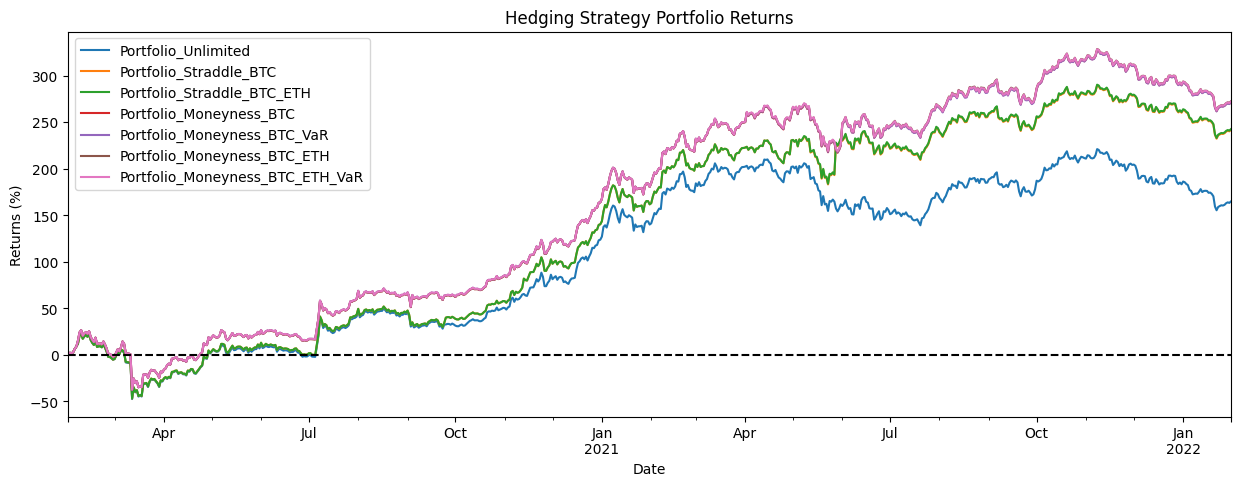

In [42]:
all_portfolio_returns.expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (15, 5))
plt.title("Hedging Strategy Portfolio Returns")
plt.ylabel("Returns (%)")
plt.axhline(y=0, color='black', linestyle='--')

plt.savefig('Hedging Strategy Portfolio Returns.png')